<a href="https://colab.research.google.com/github/Tristan-Brown1096/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/Tristan-Brown1096/DS18_Unit_2_Build_Week_Project/master/data/cbb.csv')

In [8]:
df.TEAM = [team.replace(' ', '') for team in df.TEAM]
df.SEED = df.SEED.replace(np.NaN , 0).astype(int)
df = df[df['POSTSEASON'] != 'no tourney']

In [9]:
train = df[df['YEAR'] <= 2017]
val = df[df['YEAR'] == 2018]
test = df[df['YEAR'] == 2019]

In [10]:
train['YEAR'] = train['YEAR'].astype(str)
val['YEAR'] = val['YEAR'].astype(str)
test['YEAR'] = test['YEAR'].astype(str)
train['ID'] = train.TEAM + train.YEAR
val['ID'] = val.TEAM + val.YEAR
test['ID'] = test.TEAM + test.YEAR

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [11]:
train = train.set_index('ID')
val = val.set_index('ID')
test = test.set_index('ID')

In [12]:
target = 'POSTSEASON'

In [13]:
X_train = train.drop([target, 'TEAM', 'YEAR', 'SEED', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)
y_train = train[target]

X_val = val.drop([target, 'TEAM', 'YEAR', 'SEED', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)
y_val = val[target]

X_test = test.drop([target, 'TEAM', 'YEAR', 'SEED', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)
y_test = test[target]

In [14]:
baseline = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline)

Baseline Accuracy: 0.4731977818853974


In [17]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score

In [18]:
model_1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_estimators=500, max_depth=5, max_features=None, criterion='entropy')
)

model_1.fit(X_train, y_train)
print('Training Accuracy:', model_1.score(X_train, y_train))
print('Validation Accuracy:', model_1.score(X_val, y_val))
print('Test Accuracy', accuracy_score(y_test, model_1.predict(X_test)))

Training Accuracy: 0.7874306839186691
Validation Accuracy: 0.5882352941176471
Test Accuracy 0.6029411764705882


In [51]:
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_plot, pdp_interact_plot
import matplotlib.pyplot as plt

In [53]:
oe = OrdinalEncoder()
model = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=5, max_features=None, criterion='entropy')
model.fit(oe.fit_transform(X_train), y_train)

oe.mapping

[{'col': 'CONF', 'data_type': dtype('O'), 'mapping': ACC      1
  B10      2
  WCC      3
  BE       4
  B12      5
  P12      6
  SEC      7
  A10      8
  Amer     9
  BW      10
  CUSA    11
  Ivy     12
  MVC     13
  MWC     14
  SB      15
  Slnd    16
  AE      17
  ASun    18
  BSky    19
  BSth    20
  CAA     21
  Horz    22
  MAAC    23
  MAC     24
  MEAC    25
  NEC     26
  OVC     27
  Pat     28
  SC      29
  Sum     30
  SWAC    31
  WAC     32
  P10     33
  NaN     -2
  dtype: int64}]

In [74]:
oe.category_mapping

[{'col': 'CONF', 'data_type': dtype('O'), 'mapping': ACC      1
  B10      2
  WCC      3
  BE       4
  B12      5
  P12      6
  SEC      7
  A10      8
  Amer     9
  BW      10
  CUSA    11
  Ivy     12
  MVC     13
  MWC     14
  SB      15
  Slnd    16
  AE      17
  ASun    18
  BSky    19
  BSth    20
  CAA     21
  Horz    22
  MAAC    23
  MAC     24
  MEAC    25
  NEC     26
  OVC     27
  Pat     28
  SC      29
  Sum     30
  SWAC    31
  WAC     32
  P10     33
  NaN     -2
  dtype: int64}]

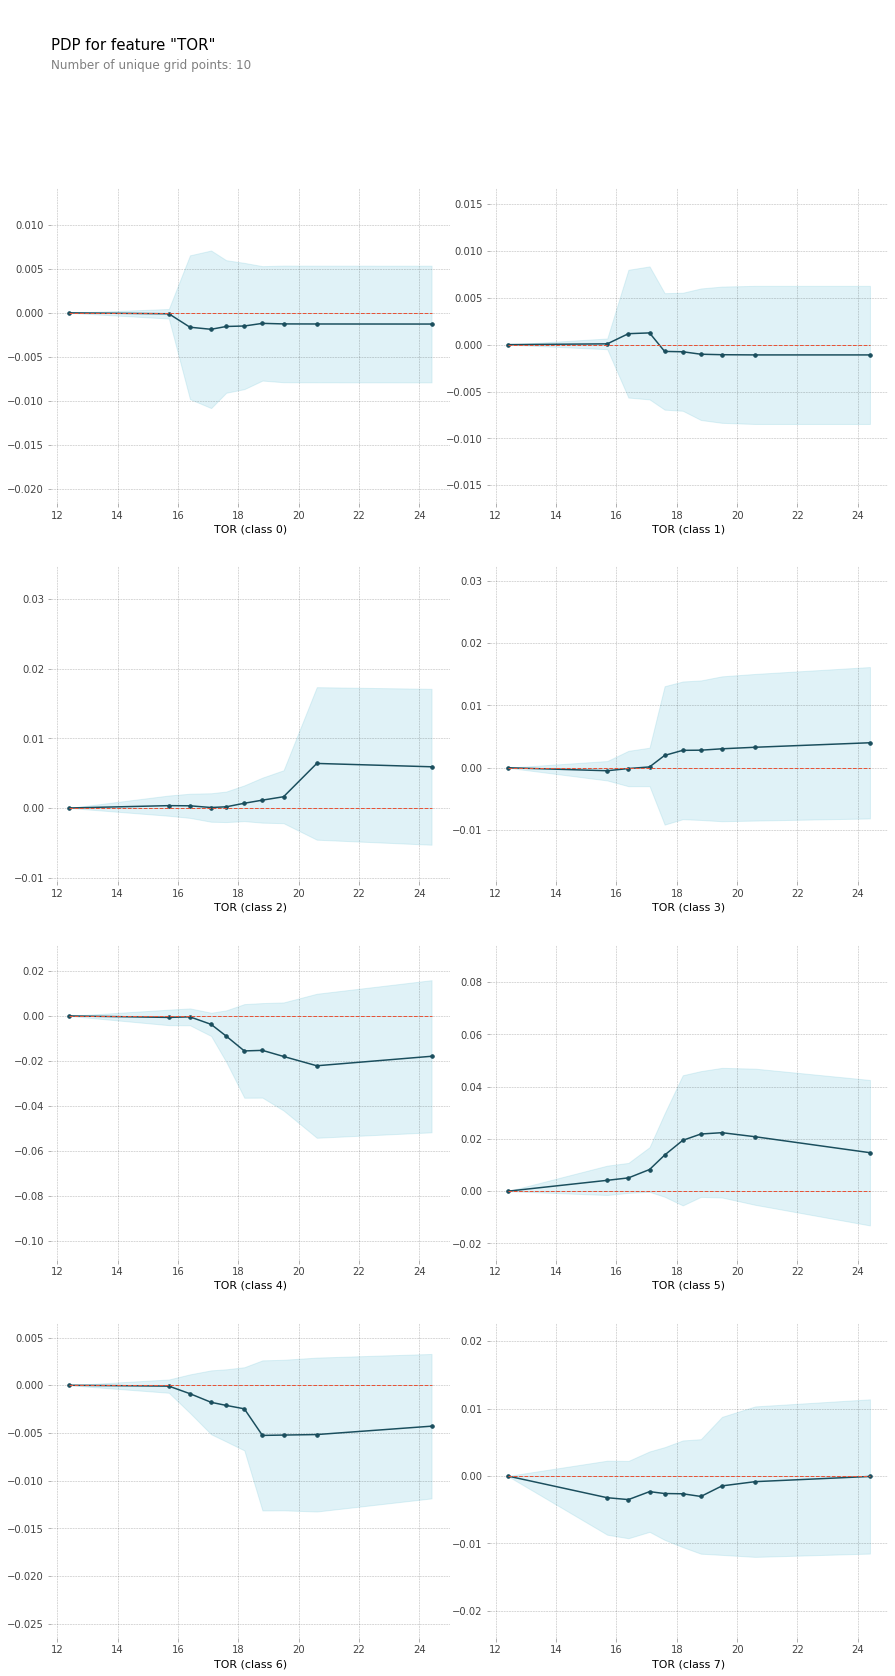

In [80]:
feature='TOR'
iso = pdp_isolate(
    model=model,
    dataset=oe.fit_transform(X_train),
    model_features=X_train.columns,
    feature=feature,
    n_jobs=-1
)
fig, ax = pdp_plot(iso, feature_name=feature)
fig.set_facecolor('w')
plt.show()

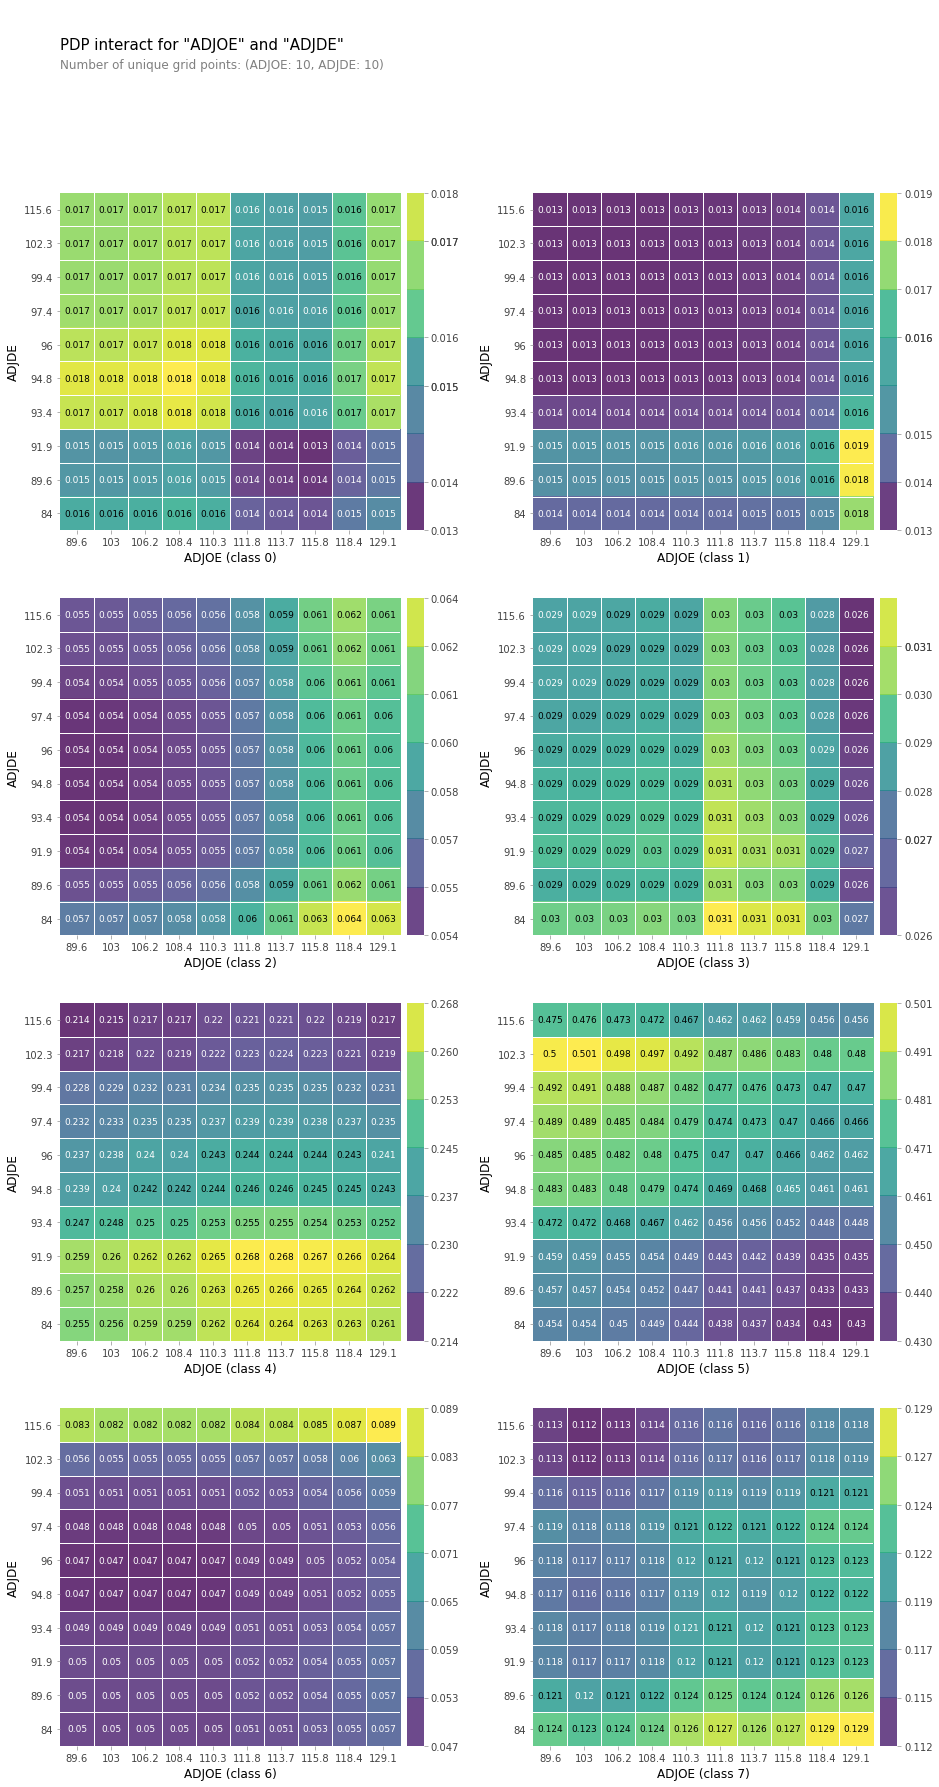

In [81]:
features = ['ADJOE', 'ADJDE']

interact = pdp_interact(
    model=model_1,
    dataset=X_train,
    model_features=X_train.columns,
    features=features
)

fig, ax = pdp_interact_plot(interact, feature_names=features, plot_type='grid')
fig.set_facecolor('w')
plt.show()

In [30]:
oe = OrdinalEncoder()
si = SimpleImputer()
Xt_train = si.fit_transform(oe.fit_transform(X_train))

In [36]:
model = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=5, max_features=None, criterion='entropy')
model.fit(X_train_processed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [45]:
processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

row = X_test.iloc[[]]

import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0], 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)